In [21]:
from time import time
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import os

# libraries to support custom function for copying.

import errno
import shutil

In [4]:
def copy(src, dest):
    try:
        shutil.copytree(src, dest)
    except OSError as e:
        # If the error was caused because the source wasn't a directory
        if e.errno == errno.ENOTDIR:
            shutil.copy(src, dest)
        else:
            print('Directory not copied. Error: %s' % e)

In [5]:
src = 'new_faces'
dest = 'new_faces/lfw_home'
copy(src,dest)

In [8]:
print(os.listdir('new_faces'))
print(os.listdir('new_faces/lfw_home'))
# path = '../LFW/lfw_home/'
path = 'new_faces'

['.ipynb_checkpoints', 'lfw-funneled.tgz', 'lfw_home', 'pairs.txt', 'pairsDevTest.txt', 'pairsDevTrain.txt']
['.ipynb_checkpoints', 'lfw-funneled.tgz', 'pairs.txt', 'pairsDevTest.txt', 'pairsDevTrain.txt']


In [9]:
# Load data
lfw_dataset = sklearn.datasets.fetch_lfw_people(data_home = path, min_faces_per_person=100,  download_if_missing = False)

#download_if_missing = False ; it prevents downloading, and generates IOError if file is missing, by dfualt value = true
# lfw_dataset = 

In [10]:
n_samples, h, w = lfw_dataset.images.shape
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_dataset.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_dataset.target
target_names = lfw_dataset.target_names
n_classes = target_names.shape[0]

In [11]:
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1140
n_features: 2914
n_classes: 5


In [12]:
# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [13]:
# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction

n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 855 faces
done in 0.099s


In [14]:
eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Projecting the input data on the eigenfaces orthonormal basis
done in 0.009s


In [15]:
#  #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 4.830s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


In [22]:
# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))

Predicting people's names on the test set
done in 0.029s
                   precision    recall  f1-score   support

     Colin Powell       0.94      0.94      0.94        64
  Donald Rumsfeld       0.96      0.78      0.86        32
    George W Bush       0.87      0.98      0.92       127
Gerhard Schroeder       0.92      0.83      0.87        29
       Tony Blair       1.00      0.82      0.90        33

         accuracy                           0.91       285
        macro avg       0.94      0.87      0.90       285
     weighted avg       0.92      0.91      0.91       285



In [23]:
print("Confusion Matrix...")
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Confusion Matrix...
[[ 60   0   4   0   0]
 [  0  25   5   2   0]
 [  3   0 124   0   0]
 [  1   0   4  24   0]
 [  0   1   5   0  27]]


In [17]:
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

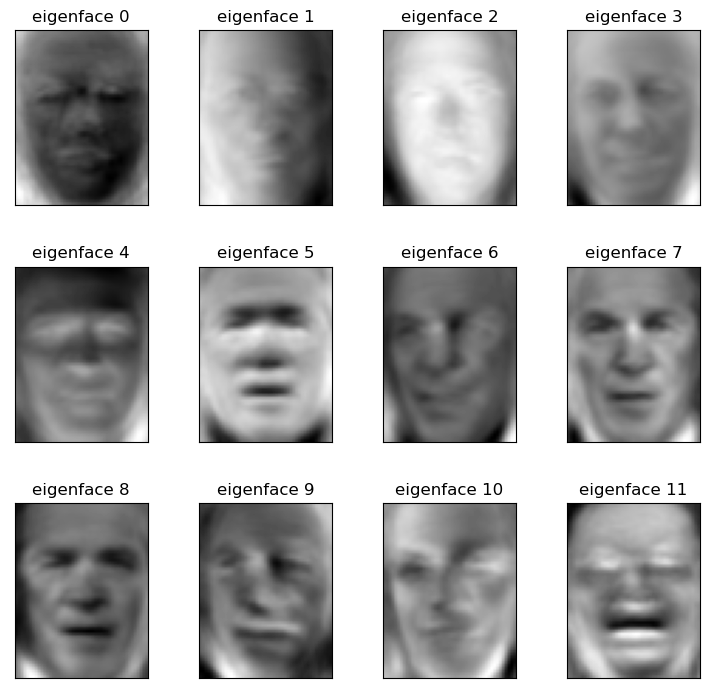

In [18]:
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

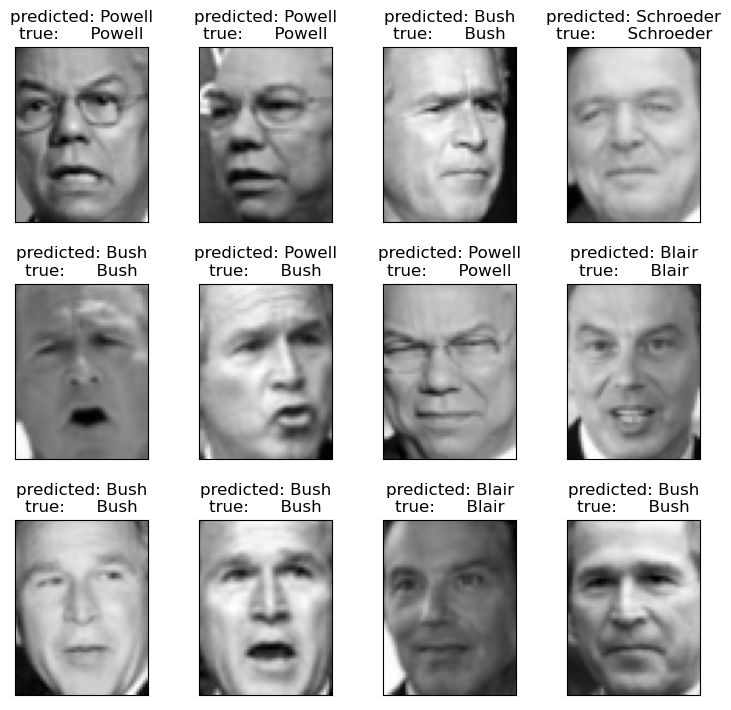

In [19]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)